# Extrapolation of trend

Some time series have marked increasing or decreasing trends that are maintained over time. When such a situation occurs, it may be reasonable to fit a curve to the past trend and extrapolate values to predict the future. Among the curves to be used are polynomial, exponential, logistic or Gompertz curves. In general, this method is recommended to estimate a long-term trend of a given univariate series (satifying the previous conditions), as it is unlikely to be worthwhile to fit a more complex model to past data. For this to work properly, it is recommended to have seven to ten years of data and not to generate forecasts for a period longer than half of the past years for which data are available. 

A drawback to this type of model is that there is no logical basis for choosing one among different curves, other than the goodness of fit. On most occasions several curves fit the series correctly, however they give very different values when extrapolating. 

# Setup

In [1]:
# data handling
import pandas as pd
import numpy as np

# visualizations
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['savefig.dpi'] = 300
import plotly.io as pio
pio.templates.default = "plotly_white"

# modeling
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from pmdarima.model_selection import train_test_split
from scipy.optimize import curve_fit
import statsmodels.api as sm

from utils import *

# filter warnings
import warnings
warnings.filterwarnings("ignore")

# set eed to replicate results
seed=123

# Data

Read saved static data (csv file) of COVID-19 cases in Spain. More info in https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos. 
These data have been previously processed to remove the weekend's lack of data by smoothing the series. For this analysis, only the variable 'Infected' is retained.

In [2]:
# load data and display first rows
df = load_last_final_data()
df = df[['Infected']]
df.head()

c:\Users\Bisite\Desktop\COVID-Dynamics-Model-Comparison\data\final-data\spanish-covid-19-data-renave-07Jul2022.csv


,Infected
Date,
2020-03-02,26.0
2020-03-03,38.0
2020-03-04,51.0
2020-03-05,75.0
2020-03-06,110.0


To make this type of model comparable to other types of models, data is divided into train and test subsets. The first one will be used to explore and extract the characteristics of the model; the second will be used for evaluation.

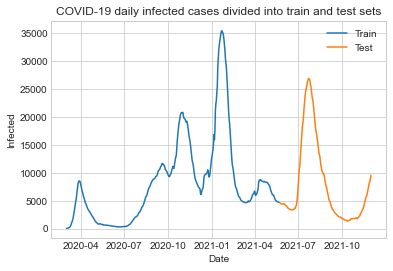

In [3]:
# divide data
train, test = train_test_split(df, test_size=0.3)
# show division
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.title('COVID-19 daily infected cases divided into train and test sets')
plt.ylabel('Infected')
plt.xlabel('Date')
plt.legend()
plt.show()

# Polynomial Regression 



In [4]:
from scipy.interpolate import InterpolatedUnivariateSpline
from sklearn.metrics import r2_score

In [5]:
class TrendExtrapolation:

    def __init__(self, window_size, steps_ahead, data,curve_type = 'poly', degree=1, metrics=metrics, eval_mode='WF'):
        # parameters
        self.window_size = window_size
        self.steps_ahead = steps_ahead
        self.degree = degree
        self.curve_type = curve_type

        # store raw data
        self.data = np.array(data)
        self.train, self.test = self.train_test_split(self.data, eval_mode)
        self.baseline = self.get_baseline(self.train)

        # metrics to evaluate
        self.metrics = metrics
        self.train_r2 = []

    def train_test_split(self, data, eval_mode='WF'):
        """
        Split data into train and test subsets
        Args:
            data (pd.DataFrame or np.array): Data to be split
            eval_mode (str): Mode of evaluation, 'WF' for Walk Forward evaluation, 'MTTS' for Multiple Train Test Splits 
        Returns:
            train (numpy.ndarray): Train data
            test (numpy.ndarray): Test data
        """
        train, test = [], []

        if eval_mode == 'WF':
            # walk forward evaluation
                train.append(np.lib.stride_tricks.sliding_window_view(data[:-(self.steps_ahead)], window_shape=self.window_size))
                test.append(np.lib.stride_tricks.sliding_window_view(data[self.window_size:], window_shape=self.steps_ahead))

        elif eval_mode == 'MTTS':
            n_windows = data.shape[1]//(self.window_size+self.steps_ahead) # perfect windows 
            data_start_point = data.shape[1]%(self.window_size+self.steps_ahead) # data start to generate perfect windows sizes
            
            window = np.array(np.split(data[data_start_point:], n_windows))
            train.append(window[:, :-self.steps_ahead])
            test.append(window[:, -self.steps_ahead:])
        else:
            raise ValueError('Evaluation mode not recognized')

        return np.array(train)[0, :, :], np.array(test)[0, :, :]

    def get_baseline(self, train):
        baseline = []
        for window in train:
            baseline.append(np.repeat(window[-1], self.steps_ahead))           
        return np.array(baseline)

    models = {}

    def fit_predict(self, window, curve_type=None, degree=None, return_only_predictions=False, log_mode=None):
        if degree is None:
            degree = self.degree
        if curve_type is None:
            curve_type = self.curve_type
            
        if curve_type == 'spline_interp':
            return self.spline_interpolation_fit_predict(window, degree, log_mode, correct_predictions=True, return_only_predictions=return_only_predictions)
        if curve_type == 'poly':
            return self.poly_fit_predict(window, degree=degree, return_only_predictions=return_only_predictions,log_mode=log_mode)
        elif curve_type == 'exp':
            return self.exp_fit_predict(window,return_only_predictions)
        elif curve_type == 'logistic':
            return self.logistic_fit_predict(window,return_only_predictions)


    def spline_interpolation_fit_predict(self, window, degree=None, log_mode=None, correct_predictions=True, return_only_predictions=False):
        if degree is None:
            degree = self.degree

        # numberical index of the day
        x = np.arange(1,len(window)+1).ravel()
        # true data from window
        y = window.ravel()

        if log_mode == 'x':
            x = np.log(x)
        elif log_mode == 'y':
            y = np.log(y)
        elif log_mode == 'xy':
            x = np.log(x)
            y = np.log(y)

        # interpolate for some order k
        model = InterpolatedUnivariateSpline(x, y, k=degree)

        # predict
        x_present = np.arange(0, self.window_size)
        x_future = np.arange(self.window_size, self.window_size+self.steps_ahead)

        fitted = model(x_present)
        prediction = model(x_future)

        # store metrics of the fit
        self.train_r2.append(r2_score(y, fitted))

        if correct_predictions:
            # change negative predictions to zero
            prediction[prediction<0] = 0

        if return_only_predictions is True:
            return prediction
        else:
            return np.concatenate((fitted, prediction))

    def poly_fit_predict(self, window, degree=None, log_mode=None, correct_predictions=True, return_only_predictions=False):
        if degree is None:
            degree = self.degree

        # numberical index of the day
        x = np.arange(1,len(window)+1).reshape(-1,1)
        # true data from window
        y = window.reshape(-1,1)

        if log_mode == 'x':
            x = np.log(x)
        elif log_mode == 'y':
            y = np.log(y)
        elif log_mode == 'xy':
            x = np.log(x)
            y = np.log(y)

        # generate polynomials
        polynomial_features = PolynomialFeatures(degree=degree)
        # fit to time steps
        xp = polynomial_features.fit_transform(x)
        # fit regression
        model = sm.OLS(y, xp).fit()
        # store metrics of the fit
        self.train_r2.append(model.rsquared)

        # predict
        x_present = np.arange(0, self.window_size)
        x_future = np.arange(self.window_size, self.window_size+self.steps_ahead)
        x_present_transformed = polynomial_features.transform(x_present.reshape(-1,1))
        x_future_transformed = polynomial_features.transform(x_future.reshape(-1,1))

        fitted = model.predict(x_present_transformed)
        prediction = model.predict(x_future_transformed)
        pred_intervals = model.conf_int(x_future_transformed) # for pred intervals but lower limit is nan

        if correct_predictions:
            # change negative predictions to zero
            prediction[prediction<0] = 0

        if return_only_predictions is True:
            return prediction
        else:
            return np.concatenate((fitted, prediction))

    def exp_model(self, x, a, k, b):
        """Exponential function"""
        return a*np.exp(-k*x)+b

    def exp_fit_predict(self, window, return_only_predictions=False):
        """
        Fit exponential function to the window and predict 
        future values
        """
        x = np.arange(0, len(window)) # time mesh
        y = window.reshape(-1) # values of the series
        p0 = (1., 1e-6, 1.) # starting search coefs
        assert len(y.shape)==1

        # fit the exp function to data using non linear least squares
        popt, pcov = curve_fit(self.exp_model, x, y, p0=p0,  maxfev=5000)

        # # get fitted parameters
        # a, k, b = popt

        # fit and predict
        fitted = self.exp_model(x, *popt)
        x_future = np.arange(self.window_size, self.window_size+self.steps_ahead)
        prediction = self.exp_model(x_future, *popt)

        if return_only_predictions is True:
            return prediction
        else:
            return np.concatenate((fitted, prediction))
    
    def logistic_model(self, x, L, k, a, b):
        """Logistic function
        
        Args:
            x: np.array of real numbers 
            L: max value of the logistic curve
            k: logistic growth rate or steepness of the curve
            b: the x value of the sigmoid's midpoint
        """
        return L / (1. + np.exp(-k * (x - a))) + b
    
    def logistic_fit_predict(self, window, return_only_predictions=False):
        """
        Fit logistic function to the window and predict 
        future values
        """
        x = np.arange(0, len(window)) # time mesh
        y = window.reshape(-1) # values of the series
        # p0 = (1., 1e-6, 1.) # starting search coefs
        assert len(y.shape)==1

        # fit the exp function to data using non linear least squares
        popt, _ = curve_fit(self.logistic_model, x, y)

        # # get fitted parameters
        # a, k, b = popt

        # fit and predict
        fitted = self.logistic_model(x, *popt)
        x_future = np.arange(self.window_size, self.window_size+self.steps_ahead)
        prediction = self.logistic_model(x_future, *popt)

        if return_only_predictions is True:
            return prediction
        else:
            return np.concatenate((fitted, prediction))

    def random_windows(self, return_baseline=False):
        """
        Generate random windows
        """
        random_index = np.random.randint(0, self.train.shape[0])
        random_window_train, random_window_test = self.train[random_index], self.test[random_index]
        if return_baseline is True:
            random_window_baseline = self.baseline[random_index]
            return random_window_train, random_window_test, random_window_baseline
        else:
            return random_window_train, random_window_test

    def plot_windows(self, max_subplots=3, plot_baseline=False):
        """
        Plot real infected data, the predictions and the baseline to compare
        Args:
            max_subplots (int): maximum number of subplots to plot
        """
        # seed to replicate results 
        np.random.seed(seed)
        
        example_windows = [self.random_windows(return_baseline=True) for _ in range(max_subplots)]

        for train_window, test_window, baseline_window in example_windows:
            t_window = np.arange(self.window_size+self.steps_ahead)

            I_simulated = self.fit_predict(train_window, curve_type=self.curve_type, degree=self.degree, return_only_predictions=False)

            plt.figure(figsize=(8, 5))
            plt.scatter(t_window[:self.window_size], train_window, color='dodgerblue', label='I real')
            plt.plot(t_window[:self.window_size], I_simulated[:self.window_size], color='orange', label='I simulated', marker='o')
            plt.plot(t_window[-self.steps_ahead:], I_simulated[-self.steps_ahead:], color='darkorange', label='I predicted', marker='o')
            plt.scatter(t_window[-self.steps_ahead:], test_window, color='blue', label='I test')
            if plot_baseline is True:
                plt.plot(t_window[-self.steps_ahead:], baseline_window,  marker='o', color='silver', label='I baseline')

            plt.ylabel('Infected')
            plt.xlabel('Time steps')
            plt.legend()
            plt.show()


    def get_all_predictions(self, horizon, degree=1):
        """
        Get all predictions in a single array for a time horizon of 'horizon'

        Args:
            horizon (int): time horizon to predict
        """
        predictions = []
        for i in range(self.train.shape[0]):
            window = self.train[i]
            I_pred = self.fit_predict(window, degree=degree, return_only_predictions=True)
            predictions.append(I_pred[(horizon-1)])
        return np.array(predictions)
    
    def get_predictions_df(self, horizon=None, subset=None):
        if horizon is None:
            horizon = self.steps_ahead        
        y_pred = []
        
        for i in range(self.train.shape[0]):
            window_train = self.train[i]
            I_simulated = self.fit_predict(window_train, return_only_predictions=True)
            y_pred.append(I_simulated)

        y_fit = pd.DataFrame(y_pred, columns=[f'y_step_{i}' for i in range(1,horizon+1)])
        if subset == 'train':
            y_fit['Date'] = df[:len(self.data)].index[self.window_size:(len(y_fit)+self.window_size)]
        elif subset == 'test':
            y_fit['Date'] = df[-len(self.data):].index[self.window_size:(len(y_fit)+self.window_size)]
        else:
            y_fit['Date'] = np.arange(0, len(self.data))

        y_fit.set_index(['Date'], inplace=True)
        return y_fit

    def get_residuals(self, horizon):
        """
        Get the residuals (residuals = expected_value-forecast_value) for a time horizon of 'horizon'
        """
        I_pred_total = self.get_all_predictions(horizon, degree=self.degree)
        I_true = self.test[:, horizon-1]
        return I_true - I_pred_total # forecast errors

    def evaluate(self):
        """
        Evaluate the performance of the model
        """
        evaluation = {}

        # evaluate per timesteps
        for i in range(self.steps_ahead):
            step_evaluation, baseline_step_evaluation = {}, {}

            test_step = self.test[:, i]
            predicted_step = self.get_all_predictions(horizon=i+1, degree=self.degree)
            baseline_step = self.baseline[:, i]

            # evaluate
            for metric_name, metric in self.metrics.items():
                try:
                    step_evaluation[metric_name] = metric(test_step, predicted_step)
                    baseline_step_evaluation[metric_name] = metric(test_step, baseline_step)
                except:
                    step_evaluation[metric_name] = np.nan
                    baseline_step_evaluation[metric_name] = np.nan

                # step_evaluation['GMRAE'] = geometric_mean_relative_absolute_error(test_step, predicted_step, y_pred_benchmark=baseline_step)
                
                evaluation[f'step_{i+1}'] = step_evaluation
                evaluation[f'baseline_step_{i+1}'] = baseline_step_evaluation

        return evaluation

## Fit 

Below is an example of using the TrendExtrapolation class to interpolate the points of a 30-point (1 month) window (window_size=30) and extrapolate 14 future values (steps_ahead=14). That is, to extract the trend for the next 14 days assuming that the current conditions will be maintained.

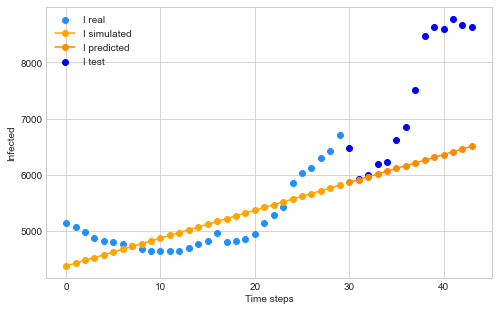

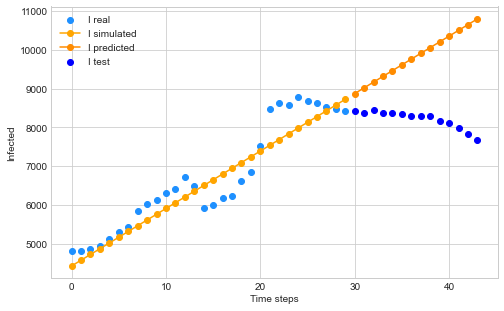

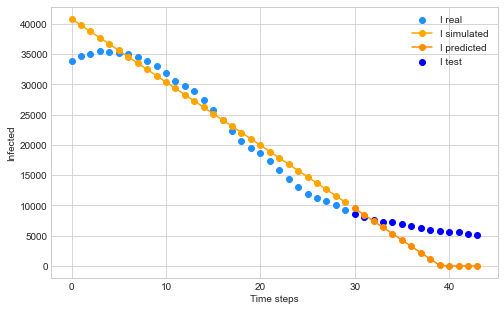

In [6]:
# create an object of the class
w = TrendExtrapolation(window_size=30, steps_ahead=14,
    curve_type='poly', # specify type of curve to fit to data
    degree=1, # specify degree of the polynomial if necessary (default=1)
    data=train['Infected']) # univariate series

# get a random train and test window
window_train, window_test = w.random_windows()
# fit the model and get the predictions
I_simulated = w.fit_predict(window_train, degree=1, return_only_predictions=True)

# fit model and plot the results for 3 random windows
w.plot_windows(max_subplots=3)

* Note that in the last window plotted, predictions twist when they reach zero. This is an a posteriori correction of the predictions. It is necessary because it does not make sense to predict negative cases. In addition, if not applied, some metrics such as RSMLE could not be calculated.

Then, this type of model can be evaluated as follows on test windows:

In [7]:
# evaluate the model
poly_1_evaluation = w.evaluate()
# show the evaluation as DataFrame
pd.DataFrame(poly_1_evaluation).style.highlight_min(axis=1)

,step_1,baseline_step_1,step_2,baseline_step_2,step_3,baseline_step_3,step_4,baseline_step_4,step_5,baseline_step_5,step_6,baseline_step_6,step_7,baseline_step_7,step_8,baseline_step_8,step_9,baseline_step_9,step_10,baseline_step_10,step_11,baseline_step_11,step_12,baseline_step_12,step_13,baseline_step_13,step_14,baseline_step_14
RMSLE,0.352669,0.048570,0.487432,0.091075,1.152033,0.131592,1.847301,0.171535,2.105766,0.210695,2.356558,0.249584,2.552832,0.288004,2.632749,0.325423,2.733377,0.362517,2.813254,0.398926,2.863361,0.434460,3.067533,0.469487,3.192854,0.504138,3.300708,0.538250
MAE,1736.278032,303.844059,2033.787629,587.472772,2341.743932,866.750000,2646.504690,1139.282178,2948.244019,1405.824257,3249.729172,1665.529703,3550.322004,1922.660891,3852.507862,2177.242574,4154.600181,2428.767327,4462.763839,2674.465347,4771.100597,2914.106436,5081.427630,3150.378713,5386.535989,3380.809406,5686.560781,3608.188119
RMSE,2819.605309,524.238616,3293.930036,985.838000,3782.508812,1423.784535,4266.700851,1857.552282,4754.347179,2285.901008,5248.574040,2711.756571,5747.805500,3131.915032,6251.181944,3538.944191,6758.364685,3937.423378,7267.965368,4324.656476,7777.420725,4699.266112,8286.014701,5062.092800,8786.715095,5414.287421,9282.162045,5754.007294
MAPE,0.222810,0.037713,0.266071,0.072373,0.311756,0.106447,0.356540,0.140368,0.398615,0.173478,0.439666,0.206813,0.479383,0.240347,0.519111,0.274668,0.559779,0.309500,0.601837,0.344273,0.645358,0.379063,0.690700,0.414276,0.737507,0.449863,0.785991,0.485786


This was just an example of using the class defined above for any window_size and steps_ahead. The objective now is to get the window_size that minimizes the prediction error on horizon 14.

## Estimation of best window size

The objective now is to find the window size that provides the best results -in general- for predicting the future 14 days. A function to evaluate different window sizes is defined below.

In [8]:
def get_best_window_size(degree, minimize_on_step=14, verbose=False):
    """
    Get the best window size for a given degree of the polynomial
    """
    start_range = degree+1
    eval_window_size = {}

    for window_size in range(start_range, 60):
        if verbose:
            print(f'Evaluating TrendExtrapolation for window size {window_size}...')

        w = TrendExtrapolation(window_size=window_size, steps_ahead=14,
            curve_type='poly', # specify type of curve to fit to data
            degree=degree, # specify degree of the polynomial if necessary (default=1)
            data=train['Infected']) # univariate series
            
        evaluation_metrics = w.evaluate()
        
        window_error = evaluation_metrics['step_14']

        eval_window_size[f'window_size_{window_size}'] = window_error

    return eval_window_size

The window size for which the metrics provide the smallest error in step 14 is sought. For this purpose, polynomials of degree 1 to 4 are evaluated over the test windows, studying window sizes from (degree+1) to 59.

In [9]:
# evaluate per degree
eval_degree = {}

for degree in range(1, 5):
    print(f'Searching best window_size for degree = {degree}...')
    eval_degree[f'deg_{degree}'] = get_best_window_size(degree)
    display(pd.DataFrame(eval_degree[f'deg_{degree}']).style.highlight_min(axis=1))

Searching best window_size for degree = 1...


,window_size_2,window_size_3,window_size_4,window_size_5,window_size_6,window_size_7,window_size_8,window_size_9,window_size_10,window_size_11,window_size_12,window_size_13,window_size_14,window_size_15,window_size_16,window_size_17,window_size_18,window_size_19,window_size_20,window_size_21,window_size_22,window_size_23,window_size_24,window_size_25,window_size_26,window_size_27,window_size_28,window_size_29,window_size_30,window_size_31,window_size_32,window_size_33,window_size_34,window_size_35,window_size_36,window_size_37,window_size_38,window_size_39,window_size_40,window_size_41,window_size_42,window_size_43,window_size_44,window_size_45,window_size_46,window_size_47,window_size_48,window_size_49,window_size_50,window_size_51,window_size_52,window_size_53,window_size_54,window_size_55,window_size_56,window_size_57,window_size_58,window_size_59
RMSLE,1.872457,1.736430,1.640084,1.708076,1.871226,2.005523,2.068699,2.066088,2.132313,2.156775,2.291133,2.471705,2.526892,2.642175,2.739088,2.798226,2.805272,2.913506,2.974250,3.024880,3.054193,3.078899,3.121489,3.212293,3.196317,3.246190,3.266557,3.292171,3.300708,3.337673,3.326288,3.343891,3.373984,3.391894,3.400461,3.409874,3.427477,3.458944,3.446873,3.485825,3.468636,3.468043,3.511972,3.493183,3.484301,3.509348,3.508090,3.520799,3.494208,3.473118,3.423568,3.408552,3.411250,3.438846,3.436697,3.467871,3.472884,3.478755
MAE,3153.569444,3193.058778,3260.451395,3355.019580,3460.566066,3570.459686,3668.585345,3765.685007,3854.622055,3939.033484,4023.140954,4109.134256,4193.629320,4289.048028,4385.952948,4483.393250,4587.211159,4690.628341,4796.317673,4900.454171,5005.139138,5104.014599,5198.084500,5286.855432,5371.316878,5457.109941,5537.793056,5614.658432,5686.560781,5759.394545,5827.320069,5894.747320,5961.338584,6026.315680,6088.425383,6149.413052,6211.515985,6268.383492,6327.484914,6382.708006,6440.057027,6494.576869,6546.932282,6597.897696,6644.944874,6689.095381,6729.628360,6773.315304,6812.962690,6852.428065,6889.860588,6923.760032,6959.117109,6992.475892,7026.444630,7057.561820,7086.119904,7114.547354
RMSE,5542.790547,5377.829931,5372.981548,5468.744136,5613.900223,5783.839818,5968.082994,6157.577696,6347.017890,6534.164536,6716.567363,6895.437723,7071.645161,7244.845117,7415.574932,7583.469121,7746.785405,7905.939992,8060.539092,8209.003524,8352.295895,8490.288410,8621.823023,8747.820896,8866.177419,8978.650555,9085.260371,9186.215006,9282.162045,9373.039413,9460.019933,9542.890071,9623.237695,9700.140058,9775.145227,9847.410695,9917.550039,9986.384963,10052.845783,10118.033661,10180.955968,10242.486850,10302.698644,10360.804706,10417.829728,10472.260757,10525.286336,10576.651277,10625.605346,10672.870296,10717.181710,10758.767941,10798.449548,10835.961605,10871.280578,10904.313313,10934.548183,10962.417644
MAPE,0.391122,0.390933,0.399656,0.411105,0.423542,0.435988,0.448373,0.462302,0.476147,0.490250,0.504935,0.519826,0.534496,0.549893,0.564149,0.578469,0.593704,0.608599,0.624104,0.640268,0.656849,0.673304,0.689933,0.706310,0.722228,0.738526,0.754449,0.770257,0.785991,0.802123,0.817176,0.832320,0.848035,0.863743,0.878748,0.893991,0.909366,0.923431,0.937809,0.951090,0.963834,0.975999,0.987980,0.998506,1.007295,1.015577,1.020479,1.024482,1.027935,1.030227,1.030280,1.029435,1.027170,1.024960,1.024152,1.022278,1.021446,1.021418


Searching best window_size for degree = 2...


,window_size_3,window_size_4,window_size_5,window_size_6,window_size_7,window_size_8,window_size_9,window_size_10,window_size_11,window_size_12,window_size_13,window_size_14,window_size_15,window_size_16,window_size_17,window_size_18,window_size_19,window_size_20,window_size_21,window_size_22,window_size_23,window_size_24,window_size_25,window_size_26,window_size_27,window_size_28,window_size_29,window_size_30,window_size_31,window_size_32,window_size_33,window_size_34,window_size_35,window_size_36,window_size_37,window_size_38,window_size_39,window_size_40,window_size_41,window_size_42,window_size_43,window_size_44,window_size_45,window_size_46,window_size_47,window_size_48,window_size_49,window_size_50,window_size_51,window_size_52,window_size_53,window_size_54,window_size_55,window_size_56,window_size_57,window_size_58,window_size_59
RMSLE,4.405534,3.935090,3.854046,3.466438,3.177227,3.227824,2.976742,3.015149,2.801727,2.820222,2.921667,2.912808,2.944963,2.805858,2.844568,2.794959,2.821404,2.826658,2.851726,2.894341,2.900884,2.940013,3.011596,2.988949,3.060587,3.013860,3.113714,3.172925,3.217722,3.245806,3.236650,3.293063,3.264270,3.332651,3.358290,3.336151,3.378827,3.424925,3.424749,3.448701,3.498040,3.492396,3.519474,3.509458,3.511609,3.534191,3.537241,3.544080,3.543717,3.584119,3.563043,3.569175,3.604678,3.604606,3.626814,3.627922,3.662740
MAE,10483.793503,7955.665465,7035.001399,6106.070895,5461.172298,4958.645582,4741.474902,4588.162993,4491.906975,4448.399450,4438.940385,4414.952670,4406.247434,4437.797057,4454.128141,4470.509106,4498.523935,4549.031903,4624.038424,4688.915811,4753.912313,4815.392803,4870.312056,4916.617297,4957.006240,5002.658140,5032.888691,5065.114938,5088.926634,5124.962973,5151.584812,5179.424142,5215.783196,5247.224036,5290.823655,5330.733091,5373.115787,5425.053878,5474.311026,5532.997340,5589.399492,5647.550994,5704.798923,5759.626501,5819.673672,5881.564516,5950.269632,6026.523331,6101.085013,6181.377818,6264.792801,6350.835401,6443.476281,6536.717324,6627.243778,6723.891925,6822.931037
RMSE,25536.664150,17840.861629,13665.715649,11138.533686,9386.696243,8262.800880,7734.994473,7489.130562,7381.906655,7333.355328,7328.673849,7353.783814,7405.873457,7494.116463,7598.332796,7690.381015,7781.463773,7877.677842,7984.971555,8098.841376,8218.583907,8335.101473,8448.665050,8553.256668,8656.801101,8753.548004,8848.809309,8938.318006,9023.743346,9112.248856,9197.020897,9283.256714,9369.119445,9450.349002,9531.657117,9609.387318,9683.260193,9756.154055,9825.301389,9892.089428,9957.798332,10020.251960,10082.169356,10143.936248,10204.923786,10267.622777,10331.208338,10396.916506,10465.134244,10535.372628,10609.245287,10686.758158,10767.206561,10851.865734,10939.724357,11031.139804,11127.665672
MAPE,1.416542,1.029064,0.895684,0.783030,0.726277,0.667237,0.632849,0.611030,0.602420,0.603909,0.603845,0.604213,0.603542,0.605310,0.606119,0.606905,0.608623,0.616463,0.627371,0.635474,0.644757,0.651568,0.656973,0.660450,0.663804,0.666398,0.667263,0.669185,0.670773,0.673759,0.677372,0.681785,0.690453,0.700160,0.712839,0.725743,0.739398,0.754309,0.769949,0.787373,0.805308,0.822589,0.839109,0.855397,0.872263,0.888520,0.904831,0.921455,0.937566,0.954020,0.970127,0.986117,1.002618,1.018684,1.034177,1.049374,1.064047


Searching best window_size for degree = 3...


,window_size_4,window_size_5,window_size_6,window_size_7,window_size_8,window_size_9,window_size_10,window_size_11,window_size_12,window_size_13,window_size_14,window_size_15,window_size_16,window_size_17,window_size_18,window_size_19,window_size_20,window_size_21,window_size_22,window_size_23,window_size_24,window_size_25,window_size_26,window_size_27,window_size_28,window_size_29,window_size_30,window_size_31,window_size_32,window_size_33,window_size_34,window_size_35,window_size_36,window_size_37,window_size_38,window_size_39,window_size_40,window_size_41,window_size_42,window_size_43,window_size_44,window_size_45,window_size_46,window_size_47,window_size_48,window_size_49,window_size_50,window_size_51,window_size_52,window_size_53,window_size_54,window_size_55,window_size_56,window_size_57,window_size_58,window_size_59
RMSLE,5.942504,5.869140,5.662746,5.526303,5.481415,5.274599,5.016193,4.976731,4.633025,4.324234,4.176733,4.133853,4.215722,4.271975,4.275309,4.285014,4.259227,4.273395,4.178223,4.102326,4.123809,4.111108,4.080357,4.085819,3.992264,3.986376,3.998044,3.844500,3.823113,3.764342,3.708011,3.683573,3.655390,3.679679,3.680692,3.793112,3.805096,3.754790,3.779812,3.778841,3.695212,3.671214,3.648565,3.620221,3.600738,3.648065,3.584347,3.610556,3.616187,3.575586,3.587053,3.515128,3.578962,3.579207,3.600688,3.617206
MAE,60346.934884,38817.478921,27209.010866,21819.883350,18612.829812,15038.402353,12689.544286,11239.301509,9983.480823,9075.911139,8400.123513,7871.452469,7683.845009,7546.301206,7394.586143,7247.937594,7163.180268,7017.053174,6912.086519,6825.336215,6758.366176,6670.521989,6593.896855,6509.491563,6455.912926,6425.230679,6434.925769,6477.913526,6520.074735,6580.752166,6651.627711,6733.570010,6823.321685,6896.627012,6974.270224,7029.830876,7077.564860,7134.118642,7177.289387,7248.826220,7293.009761,7342.625773,7392.680891,7428.005641,7471.573820,7500.810877,7536.132334,7556.031914,7590.061454,7605.748354,7631.394734,7644.147627,7658.208057,7674.370029,7687.187026,7706.757244
RMSE,191420.398623,107044.466151,67093.564945,50999.597301,39343.611839,29570.653491,23090.243169,19122.633554,16603.571982,15025.600423,13771.660847,12794.934190,12224.546092,11816.704213,11447.772974,11149.844865,10888.449800,10588.548598,10329.384419,10133.001349,9983.447535,9893.377181,9869.587613,9909.539761,9997.079365,10106.765258,10263.494201,10431.302742,10603.675753,10777.345754,10945.603000,11101.126168,11247.490071,11397.989642,11543.289097,11672.390426,11794.070598,11905.401412,12006.250038,12103.831631,12186.637500,12261.348557,12329.868894,12388.447401,12439.291398,12486.889554,12524.806252,12559.101577,12593.361715,12616.682419,12643.786596,12667.850580,12688.976253,12712.384800,12734.944373,12757.184364
MAPE,8.767778,5.213472,3.554730,2.797670,2.420384,2.028248,1.759379,1.581783,1.394781,1.239531,1.137189,1.084492,1.076750,1.077845,1.076152,1.082044,1.083509,1.080606,1.075456,1.069895,1.074811,1.072601,1.075025,1.075231,1.079414,1.086942,1.099943,1.120514,1.136574,1.155914,1.176496,1.192668,1.215372,1.233080,1.246919,1.259064,1.265515,1.275801,1.284852,1.294413,1.304942,1.314062,1.324503,1.337300,1.351732,1.365252,1.383618,1.396428,1.412338,1.426321,1.441892,1.454658,1.471003,1.487743,1.502571,1.520565


Searching best window_size for degree = 4...


,window_size_5,window_size_6,window_size_7,window_size_8,window_size_9,window_size_10,window_size_11,window_size_12,window_size_13,window_size_14,window_size_15,window_size_16,window_size_17,window_size_18,window_size_19,window_size_20,window_size_21,window_size_22,window_size_23,window_size_24,window_size_25,window_size_26,window_size_27,window_size_28,window_size_29,window_size_30,window_size_31,window_size_32,window_size_33,window_size_34,window_size_35,window_size_36,window_size_37,window_size_38,window_size_39,window_size_40,window_size_41,window_size_42,window_size_43,window_size_44,window_size_45,window_size_46,window_size_47,window_size_48,window_size_49,window_size_50,window_size_51,window_size_52,window_size_53,window_size_54,window_size_55,window_size_56,window_size_57,window_size_58,window_size_59
RMSLE,6.723916,6.459772,6.314556,6.320536,6.138097,6.133193,6.128236,6.048678,5.932243,5.805994,5.710511,5.694739,5.441424,5.202872,5.087946,5.115776,4.994756,4.981113,4.987888,4.992834,4.975510,4.910629,4.883098,4.853362,4.861694,4.811746,4.722614,4.761987,4.719323,4.666424,4.679134,4.594478,4.634391,4.534250,4.431341,4.399039,4.363118,4.227118,4.181317,4.130605,4.166804,4.158653,4.200471,4.204516,4.178377,4.212622,4.198438,4.241133,4.236200,4.311295,4.246958,4.328978,4.367390,4.368351,4.399137
MAE,410884.198135,214005.044931,137278.995985,95610.340054,72818.601931,57829.792926,45602.872528,37118.531919,30158.960221,25540.894703,21554.021892,19179.114742,17210.453861,15763.669858,14544.780635,13658.930385,13155.627099,12805.759867,12420.283790,12089.226056,11749.202639,11484.016869,11134.381939,10709.552111,10481.399831,10348.521742,10246.384530,10100.603466,10019.258851,9885.544721,9816.817883,9743.079696,9705.543186,9642.042900,9588.815557,9526.665431,9514.133558,9481.015898,9502.118922,9569.959679,9662.077976,9770.296410,9868.030576,9983.743742,10058.903123,10141.857396,10218.165607,10301.682194,10374.438583,10450.444933,10519.626932,10581.598682,10630.655075,10706.484178,10734.789398
RMSE,1435165.879741,650871.214887,394375.865345,266472.818908,199787.659978,140842.804969,101351.882028,77222.160456,61677.358935,49882.002443,41540.951122,36349.422302,32316.105290,28611.522143,25575.177804,23518.330645,22402.601305,21747.928242,21142.740781,20448.343559,19612.520239,18772.643055,17975.034869,17203.652613,16595.967510,16160.136898,15786.799855,15406.684465,15099.527174,14872.229737,14760.151178,14731.474401,14763.083487,14842.205796,14940.159842,15065.849098,15234.001705,15402.526569,15592.490598,15798.193234,16010.157958,16234.465395,16460.530089,16688.553747,16913.773174,17121.950563,17323.818377,17517.040885,17700.555778,17880.363528,18041.949197,18199.701554,18353.042164,18494.024770,18617.070515
MAPE,61.812703,29.945029,18.259256,12.286901,9.671430,7.656200,6.244046,5.259093,4.353836,3.681737,3.157237,2.746821,2.468127,2.258590,2.124637,2.052415,2.010671,1.986403,1.950954,1.916049,1.896477,1.875660,1.852107,1.827784,1.813414,1.807522,1.809277,1.810852,1.818172,1.829125,1.852362,1.876860,1.908800,1.931008,1.958968,1.990145,2.019502,2.044913,2.070405,2.101304,2.131355,2.153805,2.175823,2.187954,2.191747,2.196323,2.188582,2.173393,2.156382,2.135384,2.115750,2.095236,2.071895,2.063451,2.046004


Show the evolution of each metric as the size of each window increases. The graphs on the left correspond to the results for degree 1, those on the right to those for degree 4.

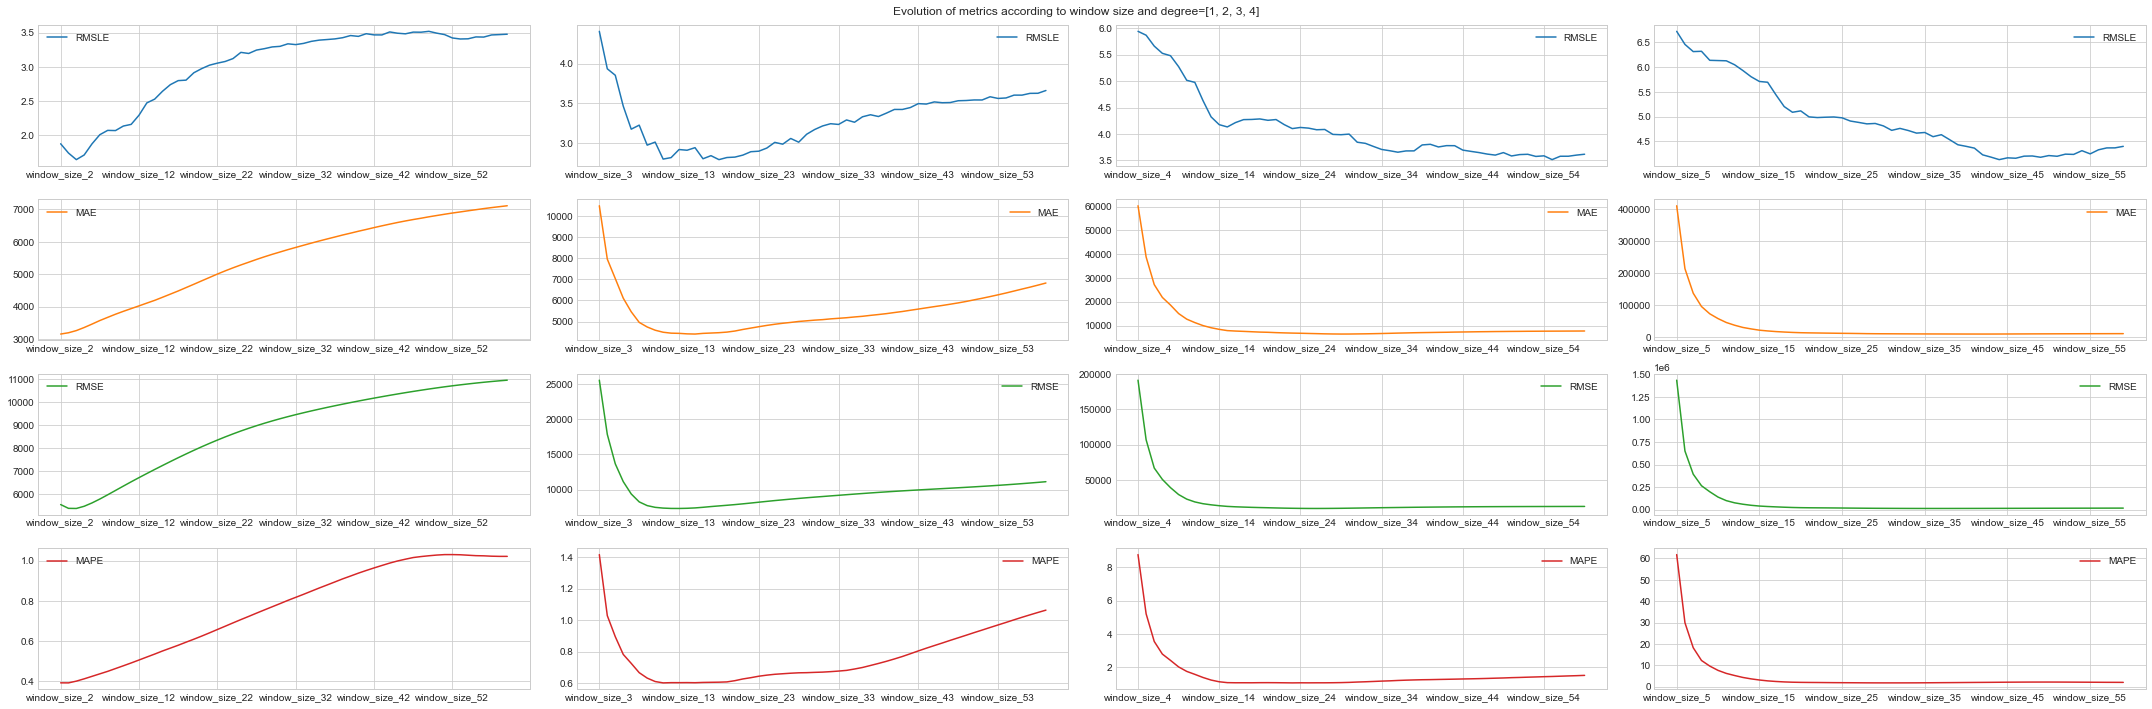

In [10]:
# metric evolution subplots
fig, axs = plt.subplots(4,4, figsize=(30, 10), tight_layout=True)

for i in range(1,5):
    pd.DataFrame(eval_degree[f'deg_{i}']).T.plot(ax=axs[:,i-1], subplots=True)

fig.suptitle('Evolution of metrics according to window size and degree=[1, 2, 3, 4]')
plt.show()

In conclusion:
- The results obtained when using polynomials of degree 1 differ from the rest: error increase with increasing window size. This means that it is best to assume that the trend of the last 4 days will continue over the next 14.
- If polynomials of degree 2 are used, a minimum is reached around window size 18. After that all errors increase. 
- For polynomials of degree 3 and 4, the errors seem to decrease the higher the number of points used. However, attention must be paid to the scale: all errors are excessively large. This phenomenon is explored below. 
- The minimum RMSLE obtained with polynomials of degree 2 is 2.79, with degree 3 is 3.51 and with degree 4 is 4.13. These values are excessively large compared to what had been obtained.

An interesting comment to make is that the window size that gives the best results for polynomials of degree 1 is 4 past points. This window size is too small for a classical regression analysis to be meaningful and robust. However, it is convenient to take into account the time sense of the series and to understand this result as meaning that the trend of the next 14 points will be set by these past 4 days. 

### Comparison of polynomials under best window size

The errors for each polynomial degree are now compared using as window size the best one found in each case. That is, the error will be the minimum possible for each polynomial. With this, the aim is to extract which polynomial provides the best predictions under the best conditions for it.

In [12]:
# retrieve best window sizes for each degree
best_window_sizes = [4, 18, 55, 44]

In [13]:
# for every evaluation saved, get the metrics for the best window size
best_metrics_per_degree = {}

best_metrics_per_degree['baseline_ws_30'] = poly_1_evaluation['baseline_step_14']

deg = 1
for deg_eval, best_window_size in zip(eval_degree.values(), best_window_sizes):
    best_metrics_per_degree[f'deg_{deg}_ws_{best_window_size}'] = deg_eval[f'window_size_{best_window_size}']
    deg +=1

pd.DataFrame(best_metrics_per_degree).style.highlight_min(axis=1)

,baseline_ws_30,deg_1_ws_4,deg_2_ws_18,deg_3_ws_55,deg_4_ws_44
RMSLE,0.538250,1.640084,2.794959,3.515128,4.130605
MAE,3608.188119,3260.451395,4470.509106,7644.147627,9569.959679
RMSE,5754.007294,5372.981548,7690.381015,12667.850580,15798.193234
MAPE,0.485786,0.399656,0.606905,1.454658,2.101304


**Some conclusions**

- The above is the minimum possible error that can be obtained for each polynomial degree used (from 1 to 4). By looking at these metrics and comparing them with the baseline metrics for the arbitrary window size used earlier (window_size=30) it can already be concluded that these types of models are not worth further study: The trivial model outperforms these models (considering RMSLE).

## Forecasts exploration


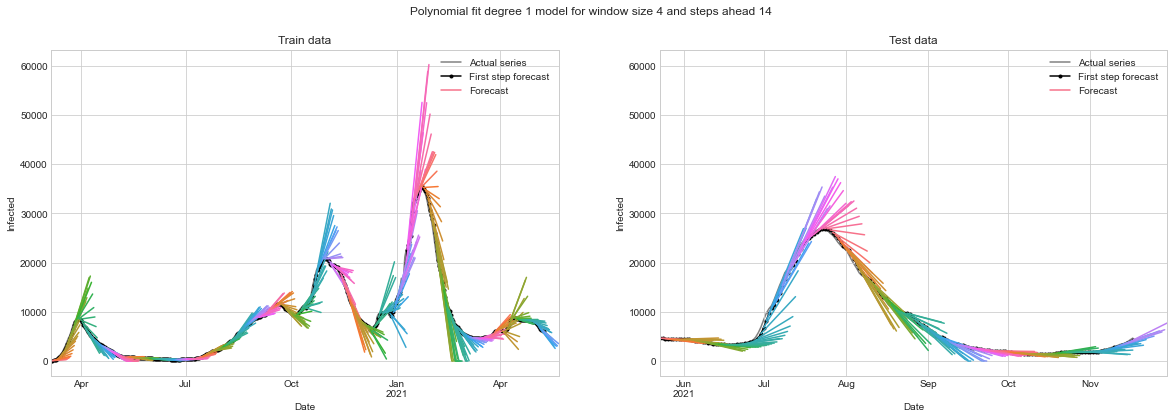

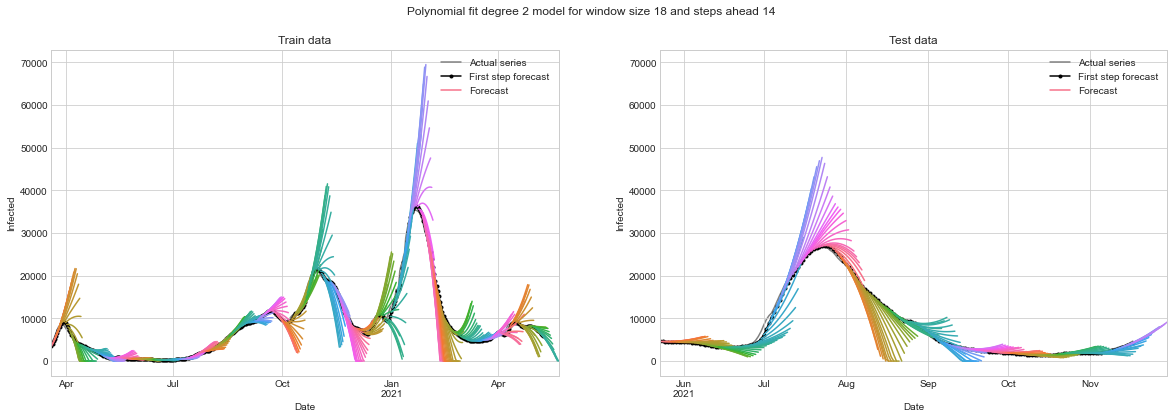

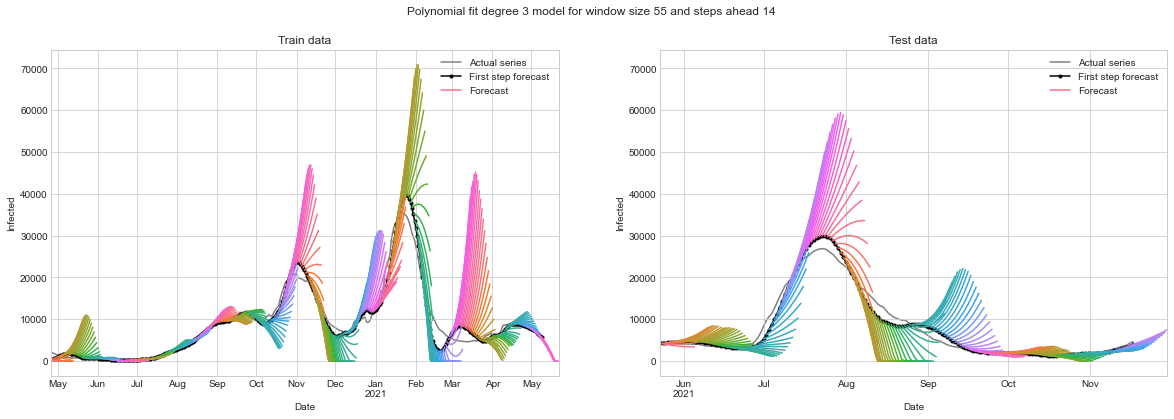

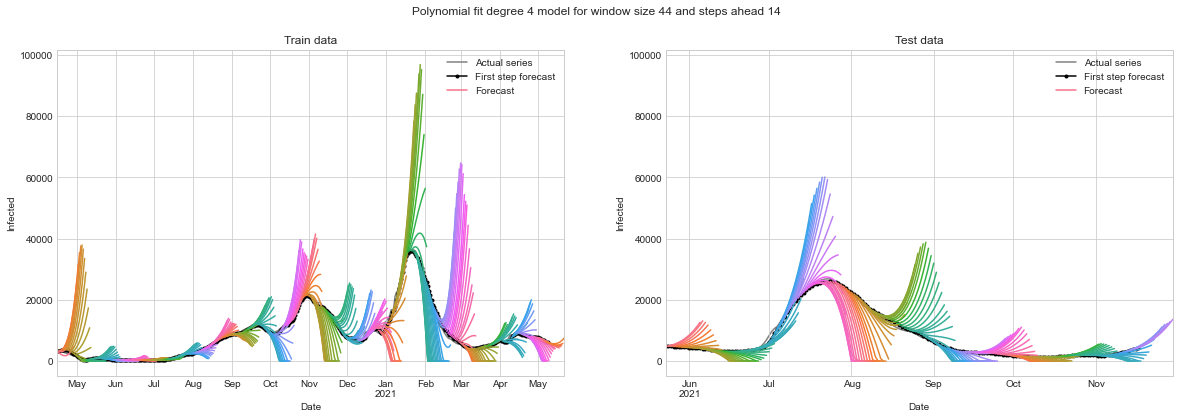

In [14]:
for degree, best_window_size in zip(range(1,5), best_window_sizes):
    w_train = TrendExtrapolation(window_size=best_window_size, steps_ahead=14,
                curve_type='poly', # specify type of curve to fit to data
                degree=degree, # specify degree of the polynomial if necessary (default=1)
                data=train['Infected']) # univariate series

    test_data = pd.concat([ train['Infected'][-best_window_size:], test['Infected'] ])

    w_test = TrendExtrapolation(window_size=best_window_size, steps_ahead=14,
                curve_type='poly', # specify type of curve to fit to data
                degree=degree, # specify degree of the polynomial if necessary (default=1)
                data=test_data) # univariate series

    y_fit_train = w_train.get_predictions_df(horizon=14, subset='train')
    y_fit_test = w_test.get_predictions_df(horizon=14, subset='test')  

    plot_all_predictions(y_fit_train, y_fit_test, df=df, model_name=f'Polynomial fit degree {degree}',window_size=best_window_size)

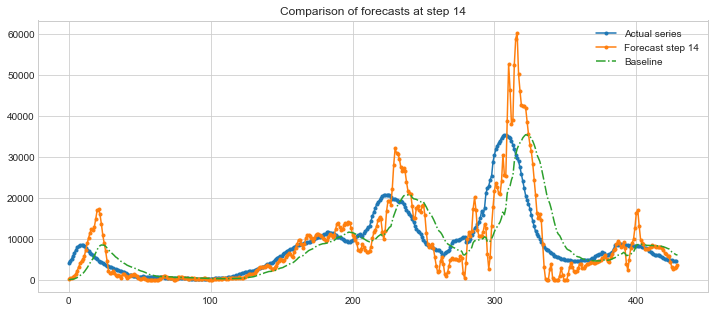

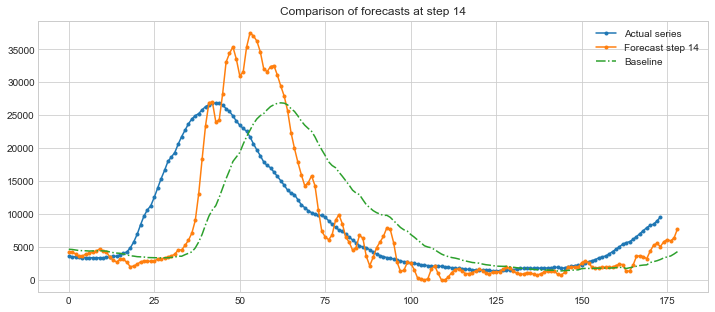

In [25]:
def compare_forecasts_at_step(y_fit, baseline, lower_ci=None, upper_ci=None, test_series=None, step=1):
    """ Compare the forecasts at a given step """

    forecasts_step = y_fit[f'y_step_{step}'].values
    base = baseline
    fig = plt.figure(figsize=(12, 5))

    plt.plot(test_series[step-1:len(y_fit)+step-1], marker='.', label='Actual series')
    plt.plot(forecasts_step, marker='.', label=f'Forecast step {step}')
    plt.plot(base, '-.', label='Baseline')

    # if prediction intervals are available, plot them
    try:
        lower_ci_step = lower_ci[f'ci_lower_step_{step}'].values
        upper_ci_step = upper_ci[f'ci_upper_step_{step}'].values
        plt.fill_between(range(len(forecasts_step)), lower_ci_step, upper_ci_step, color='lightgrey', alpha=0.5)
    except:
        pass

    plt.title(f'Comparison of forecasts at step {step}')
    plt.legend()
    plt.show()

for degree, best_window_size in zip(range(1,5), best_window_sizes):
    w_train = TrendExtrapolation(window_size=best_window_size, steps_ahead=14,
                curve_type='poly', # specify type of curve to fit to data
                degree=degree, # specify degree of the polynomial if necessary (default=1)
                data=train['Infected']) # univariate series

    test_data = pd.concat([ train['Infected'][-best_window_size:], test['Infected'] ])

    w_test = TrendExtrapolation(window_size=best_window_size, steps_ahead=14,
                curve_type='poly', # specify type of curve to fit to data
                degree=degree, # specify degree of the polynomial if necessary (default=1)
                data=test_data) # univariate series

    y_fit_train = w_train.get_predictions_df(horizon=14, subset='train')
    y_fit_test = w_test.get_predictions_df(horizon=14, subset='test') 

    # obtain data for the plots for both train and test data
    baseline_test = w_test.baseline[:,0]
    infected_test = test[w_test.window_size+1:]

    baseline_train = w_train.baseline[:,0]
    infected_train = train[w_train.window_size+1:]

    compare_forecasts_at_step(y_fit_train, baseline=baseline_train, test_series=infected_train.values, step=14)
    compare_forecasts_at_step(y_fit_test, baseline=baseline_test, test_series=infected_test.values, step=14)
    break # get only forecasts for poly degree 1

# Goodness of fit: the incorrect use of $R^2$

This section is not intended to find the best configuration for a type of model, but to compare the behavior of polynomials of different degrees under the same conditions. These set conditions are a window size of 20 points and the prediction horizon of 14 days ahead. 
The reason for including this is that some studies can be found claiming that the best prediction model is polynomials with high degrees, justifying it with the $R^2$ metric. This metric measures the amount of variance of the dependent variable explained by the independent variable, therefore it measures how well is the fit, not the forecast accuracy. 

The first step is to fit polynomials models of different degree to the data and get the predictions for step 14. As the models are fitted and predictions are extracted, the $R^2$ is also calculated on the train window.

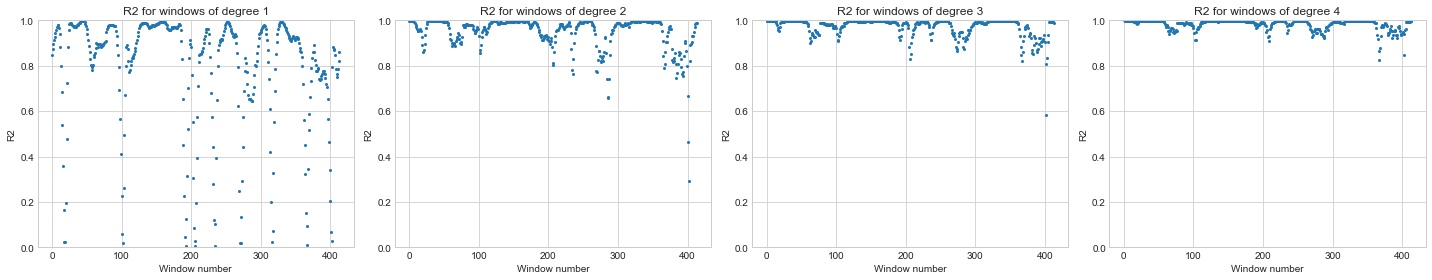

In [15]:
fig, axs = plt.subplots(1,4, figsize=(20, 4), tight_layout=True)

for degree,i in zip(range(1,5), range(0,4)):
    w = TrendExtrapolation(window_size=20, steps_ahead=14,
        curve_type='poly', # specify type of curve to fit to data
        degree=degree, # specify degree of the polynomial if necessary (default=1)
        data=train['Infected']) # univariate series

    _ = w.get_all_predictions(horizon=14, degree=degree)

    axs[i].scatter(np.arange(0, len(w.train_r2)), w.train_r2, s=4)
    axs[i].set_title(f'R2 for windows of degree {degree}')
    axs[i].set_xlabel('Window number')
    axs[i].set_ylabel('R2')

plt.setp(axs, ylim=(0,1))
plt.show()

As can be seen in the graphs, the worst R2 results are obtained using polynomials of degree 1. As the degree increases, $R^2$ increases as well and accumulates between 0.8 and 1.
The evaluation of the predictions is now checked to show that a good $R^2$ does not imply good predictions. 

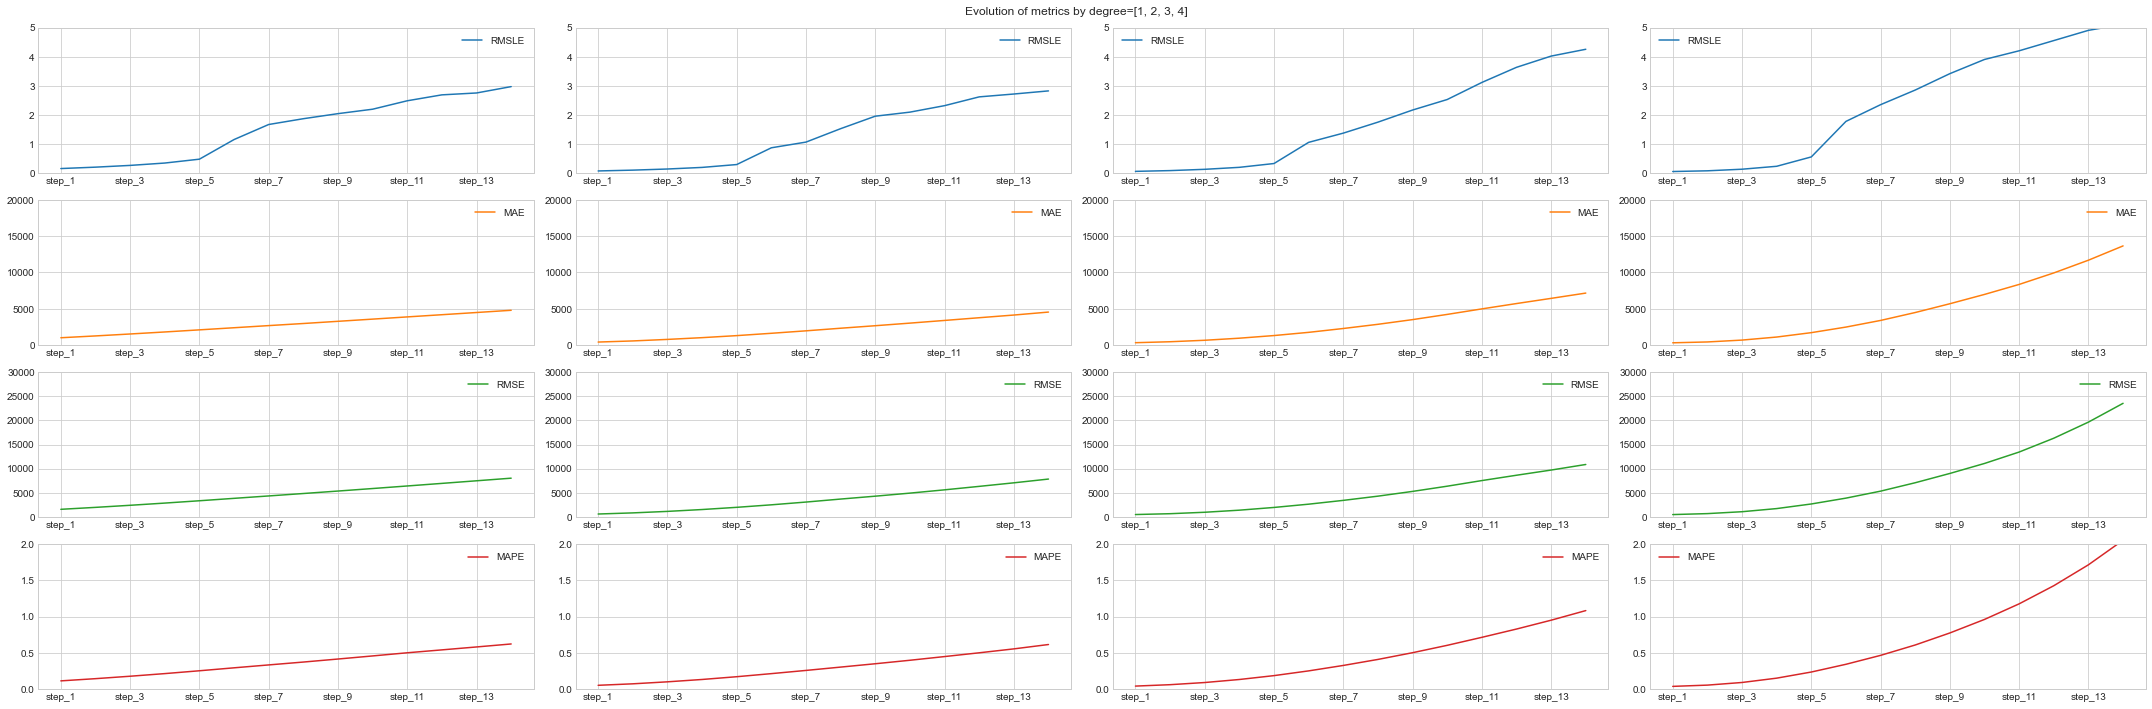

In [ ]:
fig, axs = plt.subplots(4,4, figsize=(30, 10), tight_layout=True)

for degree in range(1,5):
    
    w = TrendExtrapolation(window_size=20, steps_ahead=14,
        curve_type='poly', # specify type of curve to fit to data
        degree=degree, # specify degree of the polynomial if necessary (default=1)
        data=train['Infected']) # univariate series

    w_eval = pd.DataFrame(w.evaluate())

    # metric evolution subplots
    w_eval.loc[:,::2].T.plot(ax=axs[:,degree-1], subplots=True)

plt.setp(axs[0], ylim=(0,5))
plt.setp(axs[1], ylim=(0,20000))
plt.setp(axs[2], ylim=(0,30000))
plt.setp(axs[3], ylim=(0,2))
fig.suptitle('Evolution of metrics by degree=[1, 2, 3, 4]')
plt.show()

Polynomials of degree 1 and 2 give good results, but as the degree increases further, the predictions increase the errors. While it is normal for the error to increase as the time horizon increases, it increases faster with higher order polynomials.
This serves as an illustration of the trap of using $R^2$ to claim that a model predicts well: a good fit does not imply good predictions.

## Goodness of fit under best window size

Once the above is noted, the goodness of fit is tested under the best conditions, i.e., with the optimal window_size.

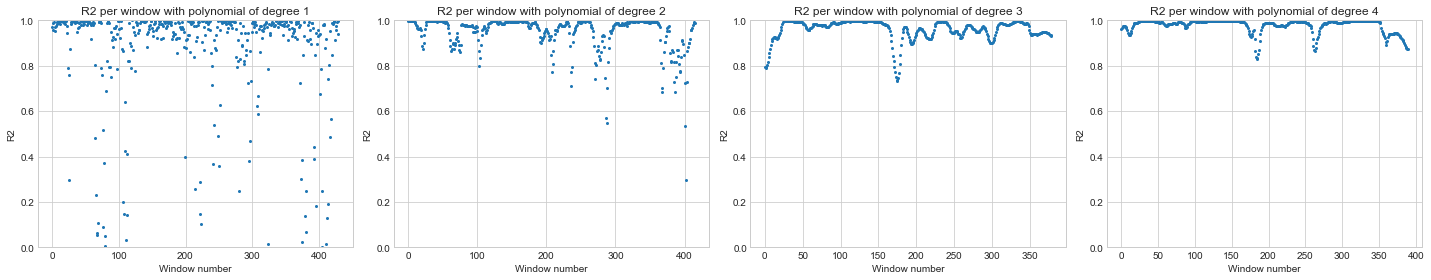

In [17]:
fig, axs = plt.subplots(1,4, figsize=(20, 4), tight_layout=True)

for degree,i in zip(range(1,5), range(0,4)):
    w = TrendExtrapolation(window_size=best_window_sizes[degree-1], steps_ahead=14,
        curve_type='poly', # specify type of curve to fit to data
        degree=degree, # specify degree of the polynomial if necessary (default=1)
        data=train['Infected']) # univariate series

    _ = w.get_all_predictions(horizon=14, degree=degree)

    axs[i].scatter(np.arange(0, len(w.train_r2)), w.train_r2, s=4)
    axs[i].set_title(f'R2 per window with polynomial of degree {degree}')
    axs[i].set_xlabel('Window number')
    axs[i].set_ylabel('R2')

plt.setp(axs, ylim=(0,1))
plt.show()

# Evaluation per degree under best $window\_size$

In [42]:
import plotly.figure_factory as ff
base_dir = Path(os.getcwd()).parents[0]
path_to_store_results = os.path.join(base_dir, 'data', 'model-evaluation-results')

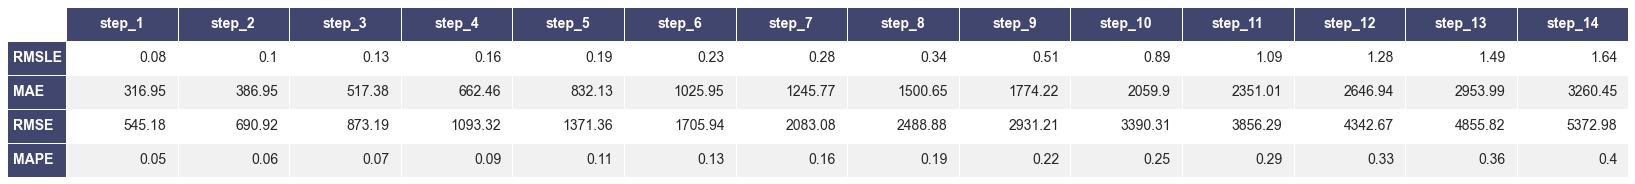

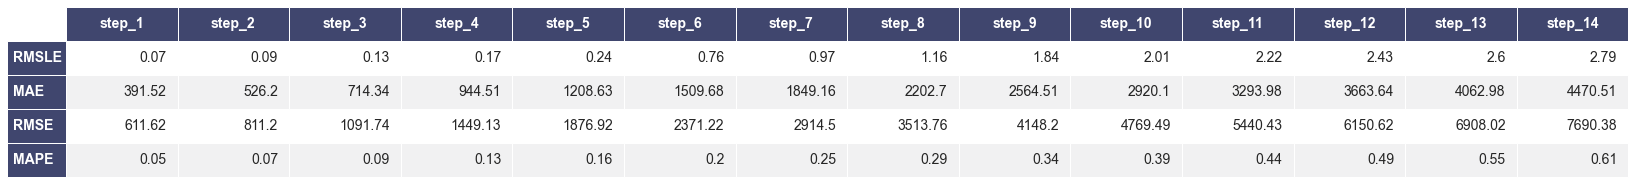

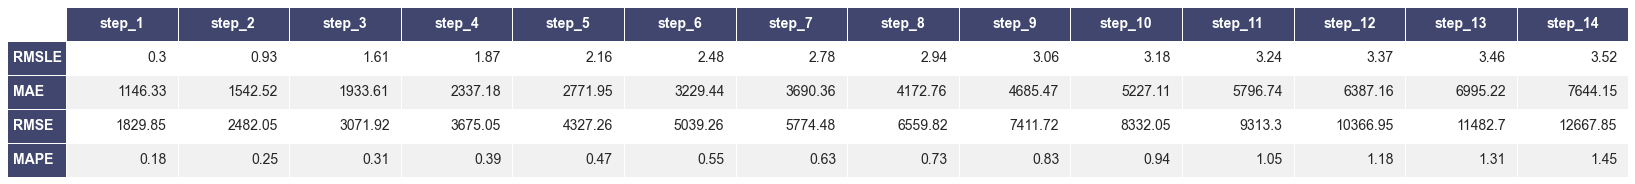

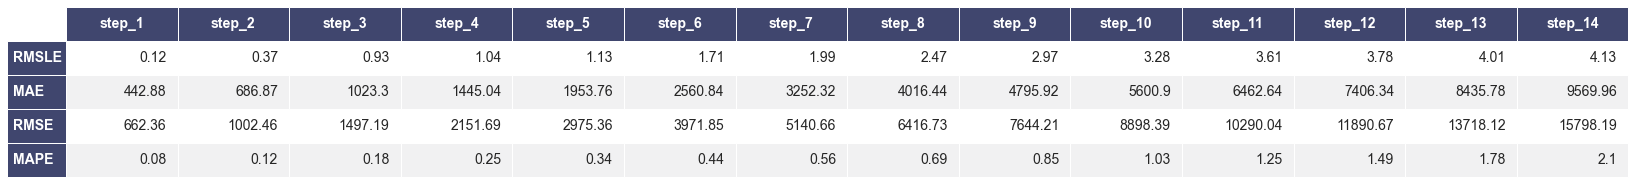

In [55]:
# get evaluation per degreee 
for degree,i in zip(range(1,5), range(0,4)):
    w = TrendExtrapolation(window_size=best_window_sizes[degree-1], steps_ahead=14,
        curve_type='poly', # specify type of curve to fit to data
        degree=degree, # specify degree of the polynomial if necessary (default=1)
        data=train['Infected']) # univariate series

    _ = w.get_all_predictions(horizon=14, degree=degree)

    # get eval
    eval = pd.DataFrame(w.evaluate()).T[::2].T

    # save evaluation df as figure
    path_to_save_image = os.path.join(path_to_store_results, f'POLY_evaluation_degree_{degree}.png')

    show_eval_table_and_save(eval, path_to_save_image)
    

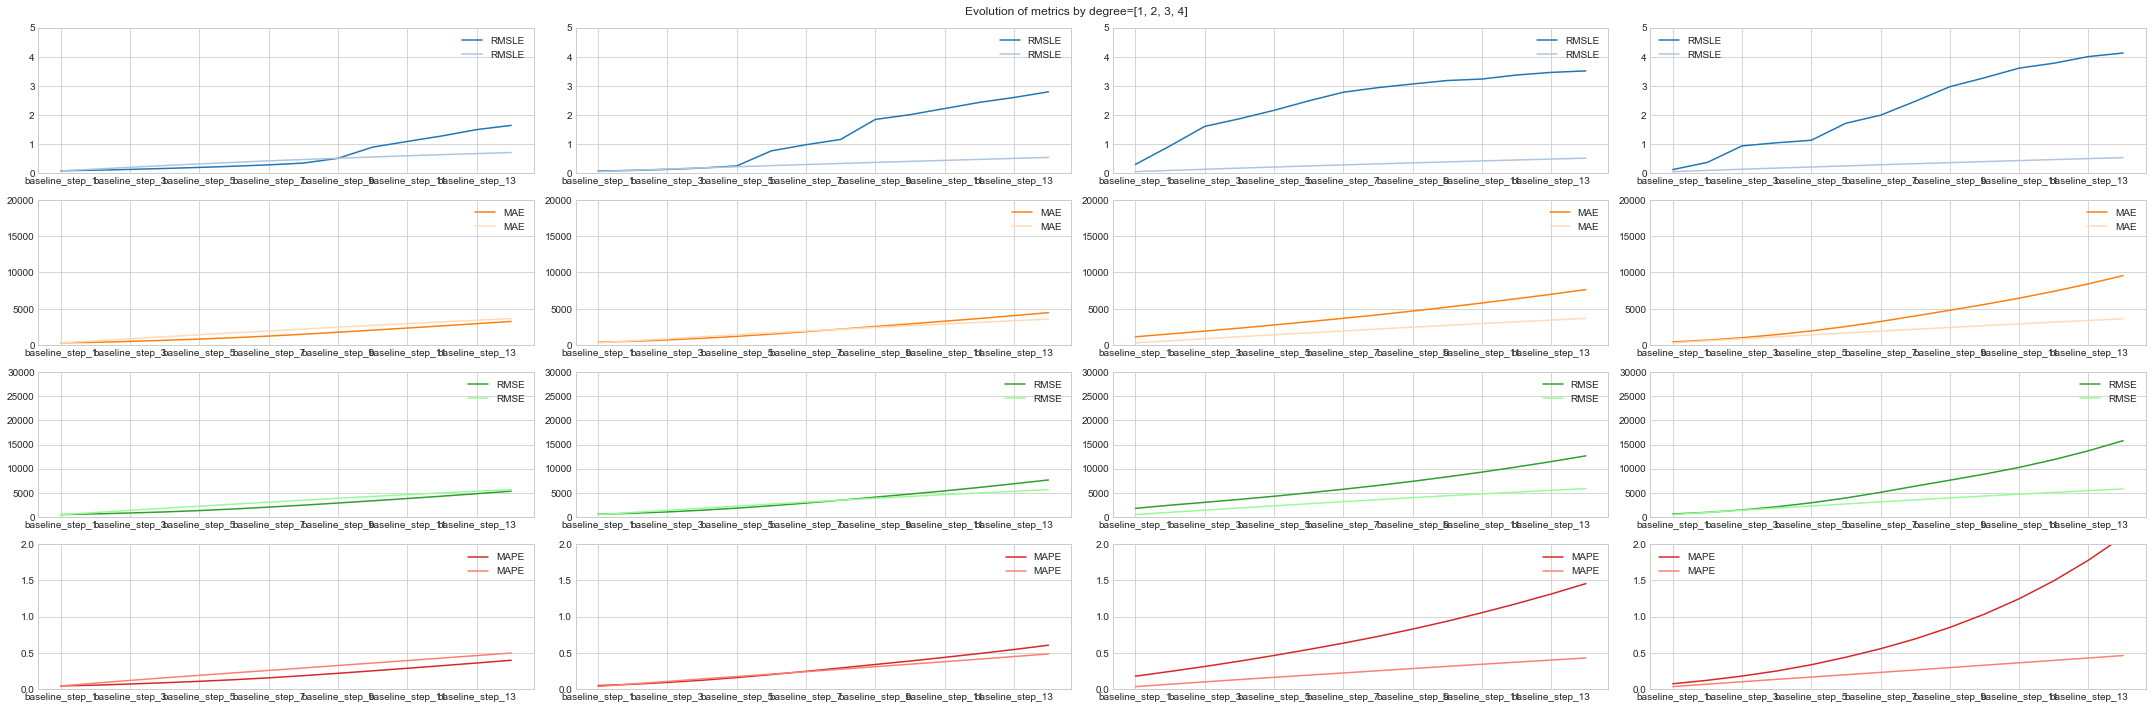

In [36]:
fig, axs = plt.subplots(4,4, figsize=(30, 10), tight_layout=True)
baseline_colors = ['lightsteelblue', 'peachpuff', 'palegreen', 'salmon']

for degree in range(1,5):
    
    w = TrendExtrapolation(window_size=best_window_sizes[degree-1], steps_ahead=14,
        curve_type='poly', # specify type of curve to fit to data
        degree=degree, # specify degree of the polynomial if necessary (default=1)
        data=train['Infected']) # univariate series

    w_eval = pd.DataFrame(w.evaluate())

    # metric evolution subplots
    w_eval.T.loc['baseline_step_1'::2,:].plot(ax=axs[:,degree-1], subplots=True, color=baseline_colors)
    w_eval.loc[:,::2].T.plot(ax=axs[:,degree-1], subplots=True)

plt.setp(axs[0], ylim=(0,5))
plt.setp(axs[1], ylim=(0,20000))
plt.setp(axs[2], ylim=(0,30000))
plt.setp(axs[3], ylim=(0,2))
fig.suptitle('Evolution of metrics by degree=[1, 2, 3, 4]')
plt.show()

# Residuals exploration

## Polynomial degree=1

In [18]:
w_train = TrendExtrapolation(window_size=best_window_sizes[0], steps_ahead=14,
    curve_type='poly', # specify type of curve to fit to data
    degree=1, # specify degree of the polynomial if necessary (default=1)
    data=train['Infected']) # univariate series

w_test= TrendExtrapolation(window_size=best_window_sizes[0], steps_ahead=14,
    curve_type='poly', # specify type of curve to fit to data
    degree=1, # specify degree of the polynomial if necessary (default=1)
    data=test['Infected']) # univariate series

In [ ]:
# obtain data for the plots for both train and test data
baseline_test = w_test.baseline[:,0]
infected_test = test_data[w_test.window_size+1:]

baseline_train = w_train.baseline[:,0]
infected_train = train_data[w_train.window_size+1:]

In [ ]:
residuals_train = w_train.get_residuals(horizon=14)
diagnostic_checking_residuals(residuals_train, standarized_residuals=True)
residuals_stats(standarize_residuals(residuals_train))

In [ ]:
residuals_test = w_test.get_residuals(horizon=14)
diagnostic_checking_residuals(residuals_test, standarized_residuals=True)
residuals_stats(standarize_residuals(residuals_test))

## Polynomial degree=2

In [ ]:
w_train_deg_2 = TrendExtrapolation(window_size=best_window_sizes[1], steps_ahead=14,
    curve_type='poly', # specify type of curve to fit to data
    degree=2, # specify degree of the polynomial if necessary (default=1)
    data=train['Infected']) # univariate series

w_test_deg_2= TrendExtrapolation(window_size=best_window_sizes[1], steps_ahead=14,
    curve_type='poly', # specify type of curve to fit to data
    degree=2, # specify degree of the polynomial if necessary (default=1)
    data=test['Infected']) # univariate series

In [ ]:
residuals_train_deg_2 = w_train_deg_2.get_residuals(horizon=14)
diagnostic_checking_residuals(residuals_train_deg_2, standarized_residuals=True)
residuals_stats(standarize_residuals(residuals_train_deg_2))

In [ ]:
residuals_test_deg_2 = w_test_deg_2.get_residuals(horizon=14)
diagnostic_checking_residuals(residuals_test_deg_2, standarized_residuals=True)
residuals_stats(standarize_residuals(residuals_test_deg_2))